# **Video Classification Home Assignment** - Tal Peer


## Table of Contents
> - Overview
> - Helper Functions
> - Datasets Class Configuration
> - Datasets Initialization - Train, Validation & Test
> - Imbalnced VS. Balanced Data for Model Training
> - Model Architecture
> - Evaluation 

## Overview
This notebook contains the final submission for the Workout video classification task. During the last week, I experimented different approaches to complete this task, including various methods for data handling, different model architectures, and different metrics for evaluating the results.

The tested architactures:
- ResNet18 Pretrained model + 2 fully connected layers
- C3D - 3D Convolutional model

I considered these two methods since temporal information is not always necessary in classification tasks. Additionally, the dataset contains videos with a duration of approximately 2 seconds, so temporal information may not significantly impact the results.

The model is trained on the given Workout dataset after splitting it into three subsets: train, validation, and test. I saved this partition within a .csv file for structural reasons and to maintain the ability to test different models later. 

These experiments were conducted in the Kaggle notebook environment, partially using a GPU P100 Accelerator.

#### Final Model Directory path (from notebook) - "/kaggle/input/task_models/pytorch/final_model/2/final_model.pth"

In [ ]:
need_install = False

if need_install:
    !pip install termcolor
    !pip install pyav
    !pip install imageio

In [3]:
import random
import os
import cv2
import imageio
import av
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
from IPython.display import Image
import matplotlib.pyplot as plt
from collections import Counter

import termcolor
from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import models, transforms
from torchvision.io import read_video
from torchvision.datasets import VisionDataset

np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device --> {device}")

Device --> cuda


### Define helper functions for plots

These function are for presenting gifs of videos from the test set, model training plots and confusion matrix.  

In [4]:
def denormalize_img(img,mean=0.5,std=0.5):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    video.shape: (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_denormalized = denormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_denormalized)
    kwargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kwargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


def show_gifs(inputs, labels, predicted):
    for j, video_tensor in enumerate(inputs):
        if j % 3 == 0:
            category_idx = labels[j].item()
            pred_category_idx = predicted[j].item()
            color = "green" if category_idx == pred_category_idx else "red"
            category_text = colored(f"True Category   -> {index_to_class[category_idx]}", color, attrs=['bold'])
            prediction_text = colored(f"Model Prediction -> {index_to_class[pred_category_idx]}", color, attrs=['bold'])
            separator = colored("=" * 50, 'light_grey', attrs=['bold'])

            print(separator)
            print(category_text)
            print(prediction_text)
            gif_image = display_gif(video_tensor.cpu())
            display(gif_image)


def plot_results(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', linewidth=2, color='#03346E')
    plt.plot(val_losses, label='Validation Loss', linewidth=2, color='#399918')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', linewidth=2, color='#399918')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


def plot_class_distribution(labels, title):
    class_counts = Counter(labels)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    sorted_classes = [classes[i] for i in sorted_indices]
    sorted_counts = [counts[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_classes, sorted_counts, color='#03346E')
    plt.xlabel('Number of Clips')
    plt.ylabel('Classes')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, normalize=True, figsize=(10, 8), cmap='Blues'):
    class_names = list(class_to_index.keys())
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='.0%', cmap=cmap, cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title('Video Classification - Confusion Matrix', fontsize=15)
    plt.show()


def get_metrics(test_losses,test_accuracies, actual_labels, model_predictions):
    test_mean_loss = np.mean(test_losses)
    test_accuracy = np.mean(test_accuracies)
    f1 = f1_score(actual_labels, model_predictions, average='macro')

    color = 'blue'
    results_text = colored("Test Results:", color, attrs=['bold', 'underline'])
    f1_text = colored(f"\tF1 Score: {f1:.4f}", color, attrs=['bold'])
    acc_text = colored(f"\tMean Accuracy: {test_accuracy:.3f}%", color, attrs=['bold'])
    loss_text = colored(f"\tMean Loss: {test_mean_loss:.3f}", color, attrs=['bold'])
    separator = colored("=" * 75, 'dark_grey', attrs=['bold'])

    print(separator)
    print(results_text)
    print(f1_text)
    print(acc_text)
    print(loss_text)
    print(separator)

    plot_confusion_matrix(actual_labels, model_predictions)

#### Define parameters needed for datasets

In [5]:
val_split_size = 0.1
test_split_size = 0.25

height = 128
width = 128
img_size = (height, width)

#### Define Image & Augmentation transformations 
Since the task is video classification, applying augmentation techniques was more challenging and computationally expensive. Additionally, the videos have low resolution and varying quality—some contain multiple people in the background, stickers, different lengths, and other inconsistencies. 
Therefore, (but mostly due to time constraints), my strategy was to begin with basic transformations, such as resizing frames to 128x128 pixels, and only modify them if necessary. 
The model's outcomes were satisfactory without requiring further augmentations.



In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

### Custom Dataset Class
I created a custom PyTorch dataset class - WorkoutDataset, needed in order to handle specifically the workout dataset. It handles the loading, processing, and transformation of the video data into multiple frames, and suitable formatting for the ResNet18 model.

In [7]:
def extract_key_frames(video_path, num_key_frames=5, diff_threshold=30):
    """
    Key frames are frames which demonstrated significant l1 difference between the previous frame.
    This function return the frames in array for later tensor stack.
    :param video_path: video path
    :param num_key_frames: number of key frames to create
    :param diff_threshold: threshold set to define a significant "change" in video
    :return: Key frames
    """
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()

    if not ret:
        raise ValueError(f"Error reading video {video_path}")

    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    key_frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(frame_gray, prev_frame_gray)
        diff_sum = np.sum(frame_diff)

        if diff_sum > diff_threshold:
            key_frames.append(frame)
            frame_count += 1
            if frame_count >= num_key_frames:
                break

        prev_frame_gray = frame_gray

    cap.release()

    if len(key_frames) < num_key_frames:
        key_frames += [key_frames[-1]] * (num_key_frames - len(key_frames))

    return key_frames


def load_video_frames(video_path, num_frames=30):
    """
    Converting each frame to numpy array and append to list
    :param video_path: Video to create frames for
    :param num_frames: number of frames to create
    :return: a list of frames
    """
    container = av.open(video_path)
    frames = []
    for frame in container.decode(video=0):
        if len(frames) >= num_frames:
            break

        img = frame.to_ndarray(format='rgb24')
        frames.append(img)
    return frames


class WorkoutDataset(torch.utils.data.Dataset):
    def __init__(self, video_paths, labels, transform=None):
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.num_videos = len(video_paths)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        """
        Convert frames to tensors - each frame is converted from (Height, Width, Channels) to (Channels, Height, Width) for matching with ResNet model dimensions, and apply transformations.
        :param idx: Video idx
        :return: Video as stacked-framed tensor, and label tensors (tuple)
        """
        video_path = self.video_paths[idx]
        label_name = self.labels[idx]
        label_index = class_to_index[label_name]

        frames = load_video_frames(video_path, num_frames=30)

        frames = [torch.tensor(frame).permute(2, 0, 1).to(device) for frame in frames]
        if self.transform:
            frames = [self.transform(frame) for frame in frames]

        frames_tensor = torch.stack(frames)
        label_tensor = torch.tensor(label_index, dtype=torch.long).to(device)

        return frames_tensor, label_tensor

## Dataset Configuration
> - Load dataset
> - Calculate the split sizes
> - Split the dataset
> - Create DataLoaders
> - Write labels to file

In [8]:
def create_csv(videos, labels, file_name=""):
    df = pd.DataFrame.from_records(zip(videos, labels), columns=["path", "label"])
    df.to_csv(f"{file_name}.csv", index=False)


dataset_path = '/kaggle/input/workoutfitness-video'
video_paths = glob(os.path.join(dataset_path, '**', '*.*'), recursive=True)
labels = [os.path.basename(os.path.dirname(path)) for path in video_paths]

num_classes = len(set(labels))
class_to_index = {l: idx for idx, l in enumerate(set(labels))}
index_to_class = {idx: l for idx, l in enumerate(set(labels))}

In [9]:
trainval_videos, test_videos, trainval_labels, test_labels = train_test_split(video_paths, labels,
                                                                              test_size=test_split_size,
                                                                              random_state=42)
train_videos, val_videos, train_labels, val_labels = train_test_split(trainval_videos, trainval_labels,
                                                                      test_size=val_split_size,
                                                                      random_state=42)

In [10]:
create_csv_files = False

if create_csv_files:
    create_csv(train_videos, train_labels, "train")
    create_csv(val_videos, val_labels, "val")
    create_csv(test_videos, test_labels, "test")

### Consider sampling approach for balancing data

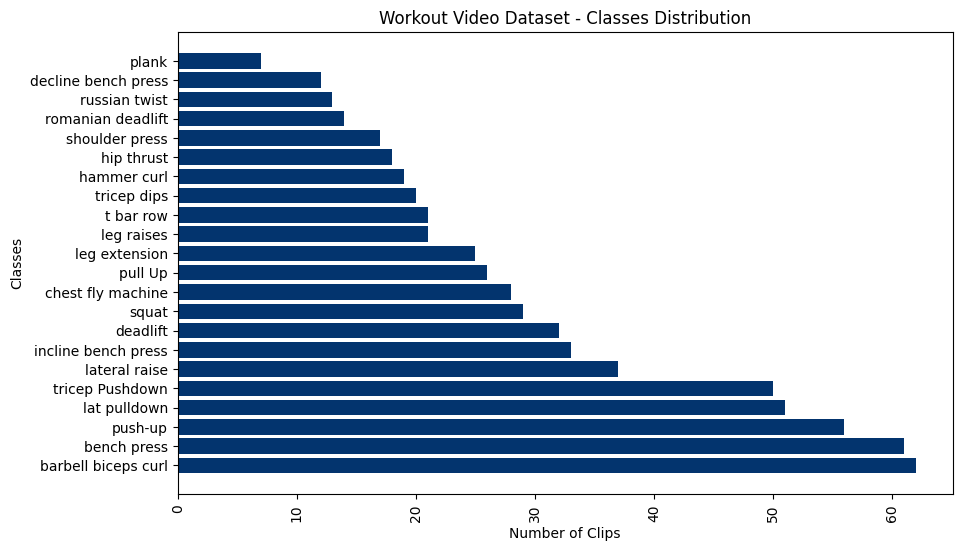

In [11]:
train_csv_path = "/kaggle/input/paths-dfs/train.csv"
val_csv_path = "/kaggle/input/paths-dfs/val.csv"
test_csv_path = "/kaggle/input/paths-dfs/test.csv"

train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

df = pd.concat([train_df, val_df], axis=0)
df = pd.concat([df, test_df], axis=0)
num_samples = df.shape[0]
class_counts = df.label.value_counts().to_dict()

plot_class_distribution(class_counts, 'Workout Video Dataset - Classes Distribution')

#### Define WeightedSampler for balanced training

I have tried two approaches for the model training - balanced data using a WeightedRandomSampler, and without any sampling. The goal was to address class imbalance by assigning higher weights to less frequent classes, ensuring that each class was represented equally during training.

Whether to apply balancing techniques is highly dependent on the context and domain, and it should be one of the primary considerations when developing a model. However, since I was using a pretrained model, I decided to try both approaches from the outset, with the understanding that I would choose the one that delivered the best performance.

Given that the model is based on a pretrained ResNet18 (originally designed for image classification), my expectation was that balancing the dataset might improve the model's performance. However, the results showed that the model actually performed better without balancing, indicating that the inherent features learned from the pretrained model were sufficient to handle the class distribution in this particular case.

Therefore, due to the better performance of the model trained on imbalanced data, this is the final model for the task. However, both approaches are provided for reference. 

In [12]:
class_weights = {cat: num_samples / count for cat, count in class_counts.items()}
all_weights = [class_weights[label] for label in train_df['label'].values]

n_samples = len(all_weights)
sampler = WeightedRandomSampler(weights=all_weights, num_samples=n_samples, replacement=False)

### **Model performance with balanced training data** -
#### Metrics scores:

<img src="plots/balanced_metrices.png" />


#### Initial training
<img src="plots/balanced_model2_try1.png"/>

### loading model state dict for more epochs:
<img src="plots/balanced_model2_try2.PNG" />

#### Confusion Matrix of Test set

<img src="plots/balanced_cm.png" />

### Create Dataset objects & Dataloaders

In [13]:
train_dataset = WorkoutDataset(train_df['path'].values, train_df['label'].values, transform=transform)
val_dataset = WorkoutDataset(val_df['path'].values, val_df['label'].values, transform=transform)
test_dataset = WorkoutDataset(test_df['path'].values, test_df['label'].values, transform=transform)

balanced_train = False

if balanced_train:
    train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=8, sampler=sampler)
else:
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

### Model Architecture

The model architecture is based on ResNet18 with the addition of two fully connected layers. The input to the model is a tensor with the shape (batch_size, num_frames, 3, 224, 224), where each video in a batch is represented by a sequence of frames. 

Initially, all frames from a video are flattened into the batch dimension, allowing each frame to be treated as an individual image. These frames are then passed through the ResNet18 base model, which extracts feature representations for each frame. 

After the ResNet18 processing, a temporal average is computed over all frames, which aggregates the features across the temporal dimension and results in a single feature vector for each video. This averaged feature vector is then passed through the fully connected layers, which perform the final classification by leveraging the aggregated information from all frames in the video.

Pretrained ResNet18 Documentaion - https://pytorch.org/hub/pytorch_vision_resnet/

In [14]:
class WorkoutClassifier(nn.Module):
    def __init__(self, num_classes=22):
        super(WorkoutClassifier, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(-1, c, h, w)
        x = self.base_model(x)
        x = x.view(batch_size, num_frames, -1)
        x = torch.mean(x, dim=1)  # Temporal average
        x = self.fc1(x)
        x = self.fc2(x)
        return x

#### Define Model & Hyperparameters
- Final Model Loading (trained on imbalanced data) 
- Optimizer - ADAM 
- Loss function - Cross Entropy for multiclass classification
- LR Scheduler (optional)

> For balanced trained model, set **"load_balanced_model=True"** variable at the next cell

In [ ]:
load_balanced_model = False
model_path = "models/final_model.pth"
balanced_model_path = "models/balanced_model.pth"
model = WorkoutClassifier(num_classes=num_classes)

if not torch.cuda.is_available():
    if load_balanced_model:
        model.load_state_dict(torch.load(balanced_model_path,map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    
else:
    print("Started GPU Acceleration")
    if load_balanced_model:
        model.load_state_dict(torch.load(balanced_model_path))
    else:
        model.load_state_dict(torch.load(model_path))
    model.to(device)

In [16]:
lr = 1e-4
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
step_size_decay = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size_decay, gamma=gamma)

## Model Training & Valuation

In [18]:
train_losses = []
val_losses = []
val_accuracies = []

num_epochs = 3
max_gained_acc = 0
epoch_of_max_acc = 0

early_stopping = False
epochs_tolerance = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}')

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    if val_accuracy >= max_gained_acc:
        max_gained_acc = round(val_accuracy, 4)

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%')

    if val_accuracy >= max_gained_acc:
        max_gained_acc = val_accuracy
        epoch_of_max_acc = epoch
    if early_stopping:
        if epoch - epoch_max_acc > epochs_tolerance:
            break

100%|██████████| 52/52 [03:39<00:00,  4.22s/it]


Epoch 1/3, Train Loss: 1.3102
Validation Loss: 0.8626, Validation Accuracy: 78.3784%


100%|██████████| 52/52 [03:38<00:00,  4.20s/it]


Epoch 2/3, Train Loss: 0.3138
Validation Loss: 0.5633, Validation Accuracy: 85.1351%


100%|██████████| 52/52 [03:38<00:00,  4.20s/it]


Epoch 3/3, Train Loss: 0.1587
Validation Loss: 0.4901, Validation Accuracy: 89.1892%


#### Plot model performance

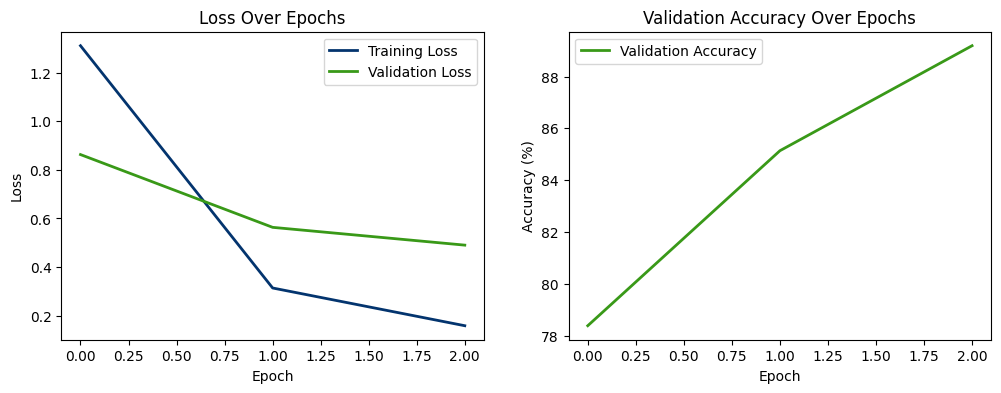

In [19]:
plot_results(train_losses, val_losses, val_accuracies)

## Model Testing

True Category   -> shoulder press
Model Prediction -> shoulder press


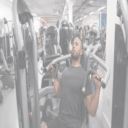

True Category   -> bench press
Model Prediction -> bench press


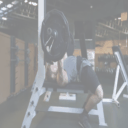

True Category   -> push-up
Model Prediction -> push-up


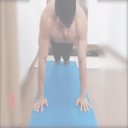

True Category   -> tricep dips
Model Prediction -> t bar row


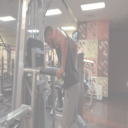

True Category   -> tricep Pushdown
Model Prediction -> tricep Pushdown


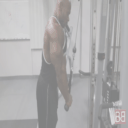

True Category   -> lateral raise
Model Prediction -> lateral raise


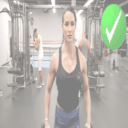

True Category   -> tricep Pushdown
Model Prediction -> tricep Pushdown


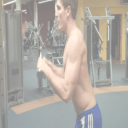

True Category   -> lat pulldown
Model Prediction -> lat pulldown


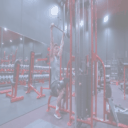

True Category   -> leg raises
Model Prediction -> leg raises


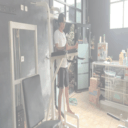

True Category   -> chest fly machine
Model Prediction -> bench press


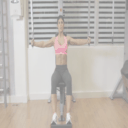

True Category   -> tricep Pushdown
Model Prediction -> tricep Pushdown


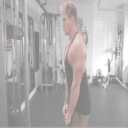

True Category   -> deadlift
Model Prediction -> chest fly machine


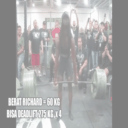

In [20]:
test_losses = []
test_accuracies = []
test_loss = 0.0
correct = 0
total = 0
cum_labels = []
cum_predicted = []

show_gifs_results = True
show_gifs_at = 5
           
model.eval()
with torch.no_grad():
    for i,(inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_accuracy = 100 * ((predicted == labels).sum().item()/ labels.size(0))
        test_losses.append(loss)
        test_accuracies.append(test_accuracy)
        cum_labels.extend(labels)
        cum_predicted.extend(predicted)
        if show_gifs_results and i % show_gifs_at == 0:
            show_gifs(inputs, labels, predicted)

## Plot Metrics
> - F1 Score (weighted)
> - Accuracy
> - Loss
> - Confusion Matrix

Test Results:
	F1 Score: 0.6687
	Mean Accuracy: 74.405%
	Mean Loss: 1.004


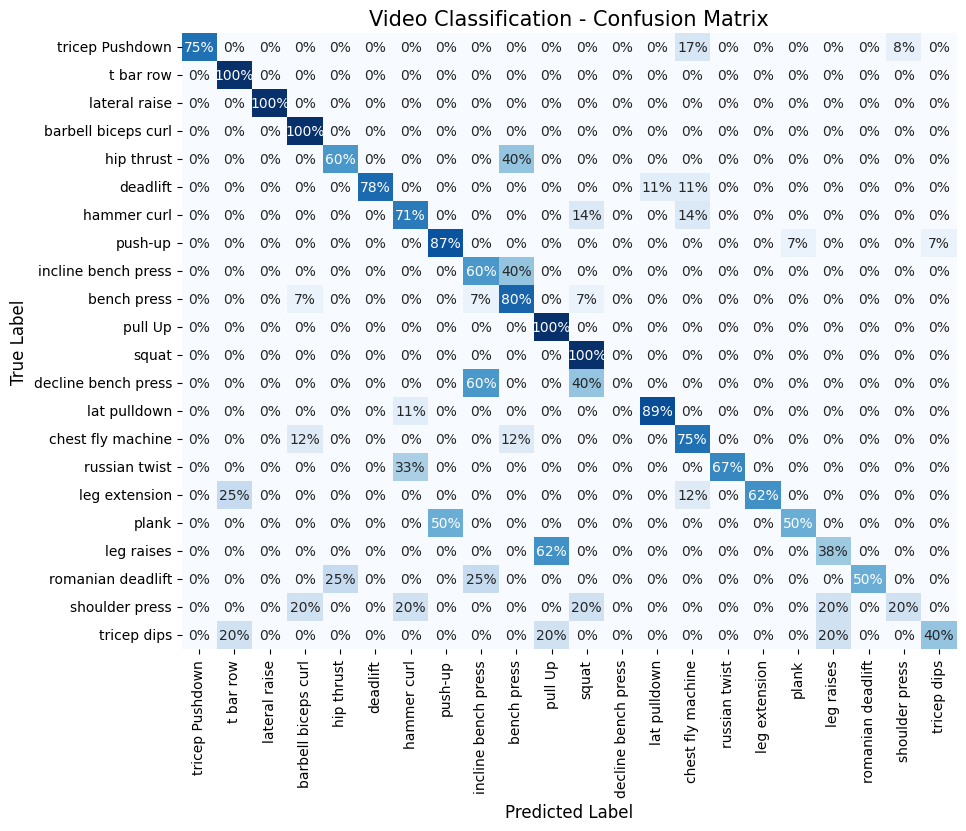

In [21]:
test_losses_cpu = [loss.cpu().numpy() for loss in test_losses]
actual_labels = [l.cpu().numpy() for l in cum_labels]
model_predictions = [p.cpu().numpy() for p in cum_predicted]

get_metrics(test_losses_cpu,test_accuracies, actual_labels, model_predictions)

### Save model

In [22]:
save_model = False
last_model_state_dict = model.state_dict()
model_path = "models/"
if save_model:
    torch.save(model.state_dict(), model_path + 'final_model.pth')